In [1]:
import glob, json, argparse, os, sys
import string

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from Bio.PDB import *

sys.path.insert(0,'/data1/groups/keatinglab/swans/savinovCollaboration/inhibitory_fragments_structure_prediction')
from src.colabfold_process_output_utils import *
from src.colabfold_process_output import *
from src.analyze_predictions import *
from src.peak_prediction import *

# Import data

In [2]:
path_to_experimental_df = '/home/gridsan/sswanson/keatinglab_shared/swans/savinovCollaboration/inhibitory_fragments_structure_prediction/data/Savinov_2022_inhib_peptide_mapping.csv'
exp_df = pd.read_csv(path_to_experimental_df)
print(len(exp_df))
exp_df.head(3)

12080


,gene,fragment ID,fragment start (aa),fragment end (aa),fragment center (aa),fragment length (aa),E = inhibitory effect (enrichment),sem(E),hydrophobicity_KyteDoolittle_classifier,instabIndex_Guruprasad_classifier,charge_Lehninger_classifier,frag_contains_alphaHelix,frag_contains_betaStrand,frag_contains_Turn,frag_centroid_fractional_position_classifier
0,EGFP-coding-pEGFP,EGFP-coding-pEGFP_16_45_+,6,15,10.5,10,0.277702,0.038327,hydrophobic,unstable,negative,1.0,1.0,0.0,N-terminal
1,EGFP-coding-pEGFP,EGFP-coding-pEGFP_16_90_+,6,30,18.0,25,-0.417512,0.105113,hydrophobic,stable,negative,1.0,1.0,0.0,N-terminal
2,EGFP-coding-pEGFP,EGFP-coding-pEGFP_16_165_+,6,55,30.5,50,-0.461540,0.310617,hydrophobic,stable,negative,1.0,1.0,0.0,N-terminal


In [3]:
exp_df = exp_df[(exp_df['fragment length (aa)']==30)&(exp_df['gene']=='ftsZ-coding-EcoliBL21DE3')]
exp_df

,gene,fragment ID,fragment start (aa),fragment end (aa),fragment center (aa),fragment length (aa),E = inhibitory effect (enrichment),sem(E),hydrophobicity_KyteDoolittle_classifier,instabIndex_Guruprasad_classifier,charge_Lehninger_classifier,frag_contains_alphaHelix,frag_contains_betaStrand,frag_contains_Turn,frag_centroid_fractional_position_classifier
2307,ftsZ-coding-EcoliBL21DE3,ftsZ-coding-EcoliBL21DE3_1_90_+,1,30,15.5,30,-0.626857,0.106985,hydrophobic,stable,negative,1.0,1.0,0.0,N-terminal
2310,ftsZ-coding-EcoliBL21DE3,ftsZ-coding-EcoliBL21DE3_4_93_+,2,31,16.5,30,-0.422974,0.118667,hydrophobic,stable,negative,1.0,1.0,0.0,N-terminal
2313,ftsZ-coding-EcoliBL21DE3,ftsZ-coding-EcoliBL21DE3_7_96_+,3,32,17.5,30,1.919863,0.156495,hydrophobic,stable,negative,1.0,1.0,0.0,N-terminal
2317,ftsZ-coding-EcoliBL21DE3,ftsZ-coding-EcoliBL21DE3_10_99_+,4,33,18.5,30,-0.581484,0.318616,hydrophilic,stable,neutral,1.0,1.0,0.0,N-terminal
2321,ftsZ-coding-EcoliBL21DE3,ftsZ-coding-EcoliBL21DE3_13_102_+,5,34,19.5,30,-0.532176,0.212105,hydrophobic,stable,neutral,1.0,1.0,0.0,N-terminal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3410,ftsZ-coding-EcoliBL21DE3,ftsZ-coding-EcoliBL21DE3_1048_1137_+,350,379,364.5,30,0.295750,0.090208,hydrophilic,unstable,neutral,1.0,0.0,0.0,C-terminal
3412,ftsZ-coding-EcoliBL21DE3,ftsZ-coding-EcoliBL21DE3_1051_1140_+,351,380,365.5,30,0.276805,0.069917,hydrophilic,stable,neutral,1.0,0.0,0.0,C-terminal
3414,ftsZ-coding-EcoliBL21DE3,ftsZ-coding-EcoliBL21DE3_1054_1143_+,352,381,366.5,30,-3.281891,1.198574,hydrophilic,unstable,neutral,1.0,0.0,0.0,C-terminal
3416,ftsZ-coding-EcoliBL21DE3,ftsZ-coding-EcoliBL21DE3_1057_1146_+,353,382,367.5,30,-3.484378,0.371092,hydrophilic,unstable,neutral,1.0,0.0,0.0,C-terminal


In [6]:
# what should the cutoff be?
print(exp_df['E = inhibitory effect (enrichment)'].mean())
print(exp_df['E = inhibitory effect (enrichment)'].std())

-1.1958645325329513
2.049121520285749


In [8]:
def zscore(data_mean,data_std,val):
    return (val - data_mean)/data_std

zscore(exp_df['E = inhibitory effect (enrichment)'].mean(),
       exp_df['E = inhibitory effect (enrichment)'].std(),
       -2.04)

-0.41194993030444305

# Call peaks in FtsZ

In [10]:
peak_df = peakFindingFromExpData(exp_df,
                                 'E = inhibitory effect (enrichment)',
                                exp_val_threshold=-2.0,
                                lookaround_distance=1,
                                grouping_distance=30,
                                max_gap_distance=5)
peak_df

1 30 5 -2.0
Found 7 peak groups in total


,fragment center (aa),peak region first fragment center (aa),peak region last fragment center (aa),peak_fragment_score,gene,fragment ID,fragment start (aa),fragment end (aa),fragment length (aa),E = inhibitory effect (enrichment),sem(E),hydrophobicity_KyteDoolittle_classifier,instabIndex_Guruprasad_classifier,charge_Lehninger_classifier,frag_contains_alphaHelix,frag_contains_betaStrand,frag_contains_Turn,frag_centroid_fractional_position_classifier
0,26.5,26.5,26.5,-2.527031,ftsZ-coding-EcoliBL21DE3,ftsZ-coding-EcoliBL21DE3_34_123_+,12,41,30,-2.527031,0.350486,hydrophobic,stable,neutral,1.0,1.0,0.0,N-terminal
1,130.5,130.5,138.5,-4.585132,ftsZ-coding-EcoliBL21DE3,ftsZ-coding-EcoliBL21DE3_346_435_+,116,145,30,-4.585132,1.284617,hydrophobic,stable,positive,1.0,1.0,0.0,central
2,149.5,149.5,149.5,-2.193510,ftsZ-coding-EcoliBL21DE3,ftsZ-coding-EcoliBL21DE3_403_492_+,135,164,30,-2.193510,0.875311,hydrophilic,stable,neutral,1.0,1.0,0.0,central
3,174.5,163.5,192.5,-9.531838,ftsZ-coding-EcoliBL21DE3,ftsZ-coding-EcoliBL21DE3_478_567_+,160,189,30,-9.531838,1.005946,hydrophobic,stable,neutral,1.0,1.0,0.0,central
4,196.5,193.5,217.5,-5.985164,ftsZ-coding-EcoliBL21DE3,ftsZ-coding-EcoliBL21DE3_544_633_+,182,211,30,-5.985164,0.763390,hydrophobic,stable,neutral,1.0,0.0,0.0,central
5,272.5,257.5,276.5,-8.707761,ftsZ-coding-EcoliBL21DE3,ftsZ-coding-EcoliBL21DE3_772_861_+,258,287,30,-8.707761,1.176845,hydrophobic,stable,neutral,1.0,1.0,0.0,C-terminal
6,368.5,366.5,368.5,-3.485854,ftsZ-coding-EcoliBL21DE3,ftsZ-coding-EcoliBL21DE3_1060_1149_+,354,383,30,-3.485854,0.607496,hydrophilic,unstable,negative,1.0,0.0,0.0,C-terminal


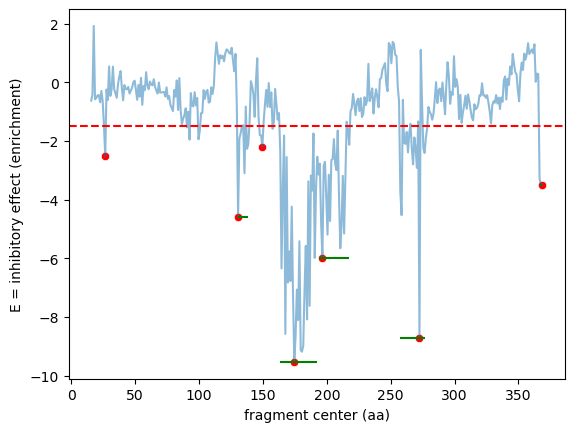

In [11]:
ax = sns.lineplot(data=exp_df,x='fragment center (aa)',y='E = inhibitory effect (enrichment)',alpha=.5)
ax.axhline(-1.5,c='r',ls='--')

plt.hlines(peak_df['peak_fragment_score'],peak_df['peak region first fragment center (aa)'],peak_df['peak region last fragment center (aa)'],
          colors='g')

fcenter = peak_df['fragment center (aa)']
wcontacts = peak_df['peak_fragment_score']
ax = sns.scatterplot(x=fcenter,y=wcontacts,color='r')

In [8]:
i = 5
lookaround_distance = 1
data = [1,2,3,4,5,6,7,8,9,10]
left_vals = data[max(i-lookaround_distance,0):i]
right_vals = data[i:min(i+lookaround_distance,len(data))]
print(left_vals)
print(right_vals)

[5]
[6]


In [9]:
peakScore(data[i],left_vals,right_vals)

0.5